In [1]:
from numba import jit
import numpy as np
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import time

In [17]:
a = 110
b = 10
a//b

11

In [22]:
@jit
def simul(N, acq_time, dt, params, random_numbers, init_state=None):
    # Unpack parameters
    mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps = params
    
    # Unpack stochastic variables (needed for numba)
    delta_x = random_numbers[0]
    delta_y = random_numbers[1]
    delta_f = random_numbers[2]

    # Initialize state variables
    x = np.zeros((N, acq_time))
    y = np.zeros((N, acq_time))
    f = np.zeros((N, acq_time))

    # Initial conditions
    if init_state is not None:
        x[:, 0] = init_state[0]
        y[:, 0] = init_state[1]
        f[:, 0] = init_state[2]

    # Time evolution (Langvine dynamics)
    for t in range(acq_time-1):
        dx = mu_x*(-k_x*x[:, t] + k_int*y[:, t])*dt + np.sqrt(2*mu_x*D_x*dt)*delta_x[:, t]
        dy = mu_y*(-k_y*y[:, t] + k_int*x[:, t] + f[:, t])*dt + np.sqrt(2*mu_y*D_y*dt)*delta_y[:, t]
        df = -(f[:, t]/tau)*dt + np.sqrt(2*eps**2*dt/tau)*delta_f[:, t]

        x[:, t+1] = x[:, t] + dx
        y[:, t+1] = y[:, t] + dy
        f[:, t+1] = f[:, t] + df
        
    
    return x, y, f

In [6]:
def simul_torch(N, T, dt, params, random_numbers, init_state=None, device='cpu'):
    # Unpack parameters
    mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps = params
    
    # Unpack stochastic variables
    delta_x, delta_y, delta_f = random_numbers

    # Initialize state variables as PyTorch tensors
    x = torch.zeros((N, T), dtype=torch.float64, device=device)
    y = torch.zeros((N, T), dtype=torch.float64, device=device)
    f = torch.zeros((N, T), dtype=torch.float64, device=device)

    # Initial conditions
    if init_state is not None:
        x[:, 0] = init_state[0].clone().detach().to(torch.float64)
        y[:, 0] = init_state[1].clone().detach().to(torch.float64)
        f[:, 0] = init_state[2].clone().detach().to(torch.float64)

    # Time evolution (Langvine dynamics)
    for t in range(T-1):
        dx = mu_x*(-k_x*x[:, t] + k_int*y[:, t])*dt + torch.sqrt(2*mu_x*D_x*dt)*delta_x[:, t]
        dy = mu_y*(-k_y*y[:, t] + k_int*x[:, t] + f[:, t])*dt + torch.sqrt(2*mu_y*D_y*dt)*delta_y[:, t]
        df = -(f[:, t]/tau)*dt + torch.sqrt(2*eps**2*dt/tau)*delta_f[:, t]

        x[:, t+1] = x[:, t] + dx
        y[:, t+1] = y[:, t] + dy
        f[:, t+1] = f[:, t] + df
        
    return x, y, f


In [24]:
def run_simul(N, acq_time, dt):
    N, acq_time = int(N), int(acq_time)

    # Define the parameters (drawn from the uniform prior)
    mu_x = np.random.uniform(0.1, 0.5, size=N)
    mu_y = np.random.uniform(0.1, 0.5, size=N)
    k_x = np.random.uniform(0.1, 0.5, size=N)
    k_y = np.random.uniform(0.1, 0.5, size=N)
    k_int = np.random.uniform(0.1, 0.5, size=N)
    D_x = np.random.uniform(0.1, 0.5, size=N)
    D_y = np.random.uniform(0.1, 0.5, size=N)
    tau = np.random.uniform(0.1, 0.5, size=N)
    eps = np.random.uniform(0.1, 0.5, size=N)

    # Initial state
    init_state = [np.random.normal(-20, 20, size=N), 
                  np.random.normal(-20, 20, size=N), 
                  np.random.normal(-0.5, 0.5, size=N)]

    # Generate random numbers for the stochastic variables
    delta_x = np.random.normal(0, 1, size=(N, acq_time))
    delta_y = np.random.normal(0, 1, size=(N, acq_time))
    delta_f = np.random.normal(0, 1, size=(N, acq_time))
    random_numbers = [delta_x, delta_y, delta_f]

    # Run the N simulations in parallel
    x, y, f = simul(N, acq_time=acq_time, dt=dt, 
                    params=[mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps], 
                    random_numbers=random_numbers, init_state=init_state)

    return x, y, f

In [7]:
def run_simul_torch(N, T):
    N, T = int(N), int(T)

    # Define the parameters (drawn from the uniform prior)
    mu_x = torch.rand(N) * 0.4 + 0.1
    mu_y = torch.rand(N) * 0.4 + 0.1
    k_x = torch.rand(N) * 0.4 + 0.1
    k_y = torch.rand(N) * 0.4 + 0.1
    k_int = torch.rand(N) * 0.4 + 0.1
    D_x = torch.rand(N) * 0.4 + 0.1
    D_y = torch.rand(N) * 0.4 + 0.1
    tau = torch.rand(N) * 0.4 + 0.1
    eps = torch.rand(N) * 0.4 + 0.1

    # Initial state
    init_state = [
        torch.normal(-20, 20, size=(N,)).clone().detach(),
        torch.normal(-20, 20, size=(N,)).clone().detach(),
        torch.normal(-0.5, 0.5, size=(N,)).clone().detach()
    ]

    # Generate random numbers for the stochastic variables
    delta_x = torch.normal(0, 1, size=(N, T))
    delta_y = torch.normal(0, 1, size=(N, T))
    delta_f = torch.normal(0, 1, size=(N, T))
    random_numbers = [delta_x, delta_y, delta_f]

    # Run the N simulations in parallel
    x, y, f = simul_torch(N, T, 0.01, [mu_x, mu_y, k_x, k_y, k_int, D_x, D_y, tau, eps], 
                          random_numbers, init_state, device='cpu')

    return x, y, f


In [26]:
# Easy call to the simulation to compile simul()
x, y, f = run_simul(N=2, acq_time=1000, dt=0.01)

In [30]:
%%time
x, y, f = run_simul(N=1e4, acq_time=1e5, dt=0.01)

In [36]:
# Trying the same with torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using '" + str('cuda' if torch.cuda.is_available() else 'cpu') + "' as device")
x, y, f = run_simul_torch(N=2, T=100)

Using 'cpu' as device


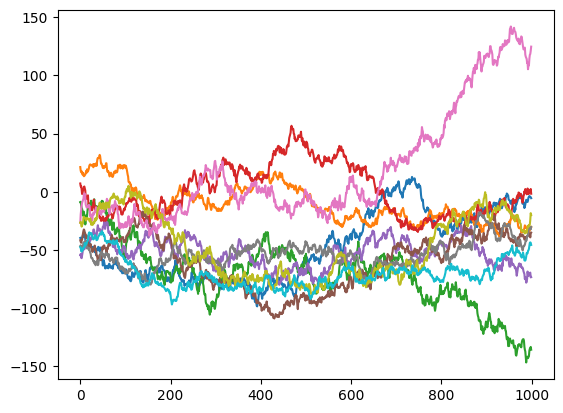

In [6]:
for n in range(10):
    plt.plot(x[n, :], label=f"Trajectory {n}")

In [7]:
%%time
N, times = int(1e4), 10
T = int(1e3)

x = np.zeros((N*times, T))
y = np.zeros((N*times, T))
f = np.zeros((N*times, T))

for t in tqdm(range(times)):
    x_t, y_t, f_t = run_simul(N, T)

    x[N*t:N*(t+1), :] = x_t
    x[N*t:N*(t+1), :] = y_t
    x[N*t:N*(t+1), :] = f_t

    #time.sleep(1)

100%|██████████| 10/10 [00:15<00:00,  1.53s/it]

CPU times: user 14 s, sys: 1.31 s, total: 15.3 s
Wall time: 15.3 s
